# Setting up environment and importing libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#enabling importing custom python files
root_path_str = "/content/drive/MyDrive/pp_cbir"
sys.path.append(root_path_str)

In [ ]:
from data_module import DataModule
from cbir_model import CBIRModel, ModelNames
from ensemble_fusion import EnsembleFusion
from helper_functions import plot_confusion_matrix, extract_features, plot_images
from attention_fusion import create_attention_model
from checkpoint_manager import CheckpointManager
from quantization import quantize_models, QuantizedModelManager, QuantizationType, QuantizedModelPredictor, compare_and_evaluate_models
from cbir_system import CBIRSystem
from cbir_evaluator import CBIREvaluator
from dataset_reader import DatasetReader

In [ ]:
#Configuration
root_dir = Path(root_path_str)
data_dir = root_dir / 'data'
checkpoint_dir = root_dir / 'checkpoints'

base_models_dir = checkpoint_dir / "default"
ensemble_dir = checkpoint_dir/ "ensemble"
attention_dir = checkpoint_dir / "attention_fused"
quantization_dir = checkpoint_dir / "quantization"

number_of_subblocks = 2
normalization = {
    "std" : [0.229, 0.224, 0.225],
    "mean" : [0.485, 0.456, 0.406]
}
batch_size = 32

# Preparing Dataset And Loading Base Models

In [ ]:
data_module = DataModule(
    data_dir,
    batch_size=batch_size,
    m=number_of_subblocks,
    normalization=normalization
)

In [ ]:
base_models = []
cbir_models = []
for model_name in ModelNames:
    cbir_model = CBIRModel(
        model_name.value,
        data_module,
        base_models_dir
    )
    model = cbir_model.model

    # Rename the loaded model
    if model.name == "sequential":
        model.name = model_name.value

    base_models.append(model)
    cbir_models.append(cbir_model)

base_models

loading model from checkpoint.........
loading model from checkpoint.........
loading model from checkpoint.........
loading model from checkpoint.........


[<Sequential name=vgg16, built=True>,
 <Sequential name=resnet50, built=True>,
 <Sequential name=densenet121, built=True>,
 <Sequential name=efficientnetb0, built=True>]

In [ ]:
#run this if the models aren't trained yet

# for cbir_model in base_models:
#     print(25*"." + f"training {cbir_model.name} model" + 25*".")
#     cbir_model.train(epochs=10)

# Base Model Results

In [ ]:
for cbir_model in cbir_models:
    print(f"Classification report for {cbir_model.model_name} :")
    print(cbir_model.get_classification_report())

Classification report for vgg16 :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1500
           1       0.87      0.99      0.93        97
           2       0.98      1.00      0.99       900

    accuracy                           0.99      2497
   macro avg       0.95      0.99      0.97      2497
weighted avg       0.99      0.99      0.99      2497

Classification report for resnet50 :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1500
           1       0.87      1.00      0.93        97
           2       0.98      0.99      0.99       900

    accuracy                           0.99      2497
   macro avg       0.95      0.99      0.97      2497
weighted avg       0.99      0.99      0.99      2497

Classification report for densenet121 :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1500
           1      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix for vgg16 :


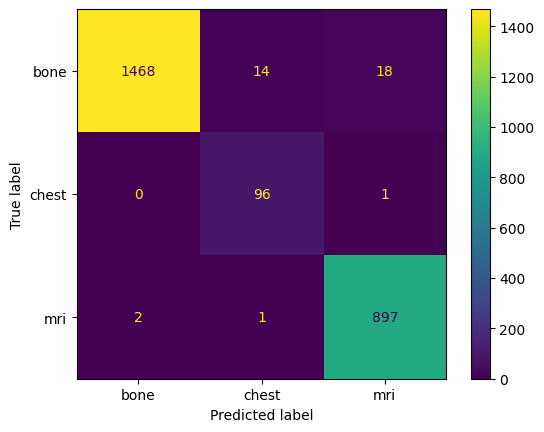

Confusion matrix for resnet50 :


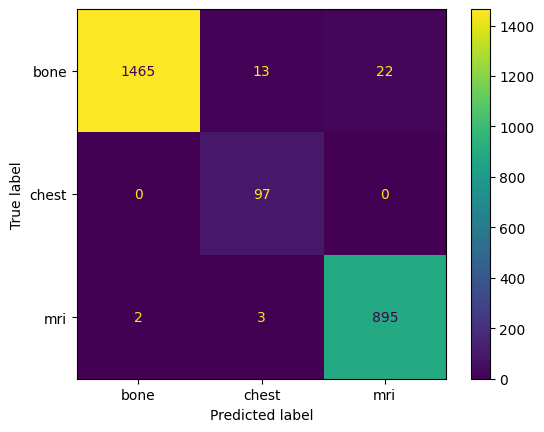

Confusion matrix for densenet121 :


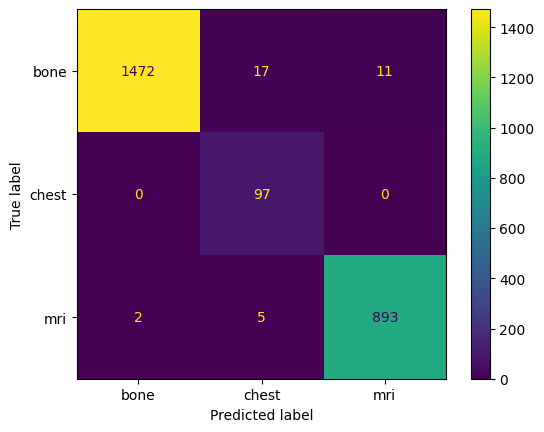

Confusion matrix for efficientnetb0 :


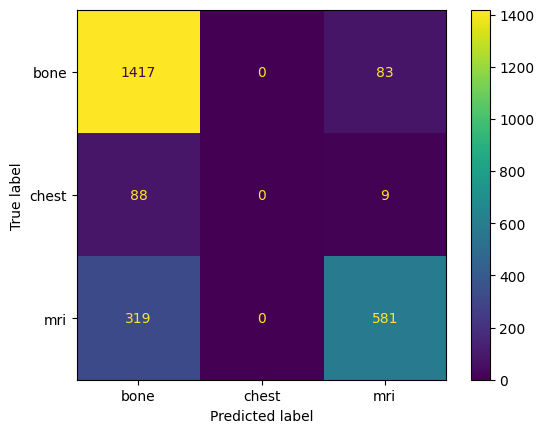

In [ ]:
for cbir_model in cbir_models:
    print(f"Confusion matrix for {cbir_model.model_name} :")
    cbir_model.plot_confusion_matrix()

#Ensemble Fusion

In [ ]:
# Initialize fusion
ensemble_fusion = EnsembleFusion(models=base_models[:3])

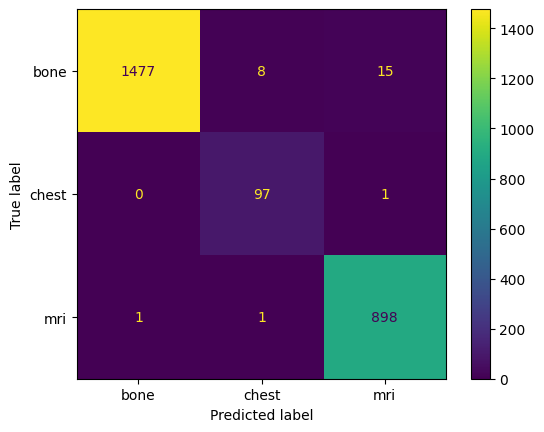

In [ ]:
# Make predictions using majority voting
mv_predictions, _ = ensemble_fusion.majority_voting_sequence(data_module.test_generator)

plot_confusion_matrix(data_module.test_generator.classes, data_module.test_generator.labels, mv_predictions, ensemble_dir, "majority_voting")

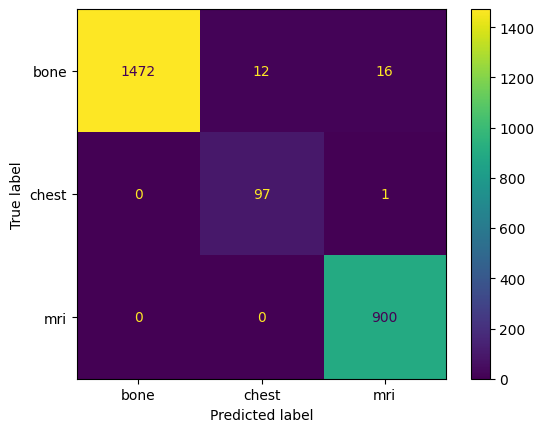

In [ ]:
# Make predictions using weighted average
weights = [0.5, 0.3, 0.2]

wa_preds, _ = ensemble_fusion.weighted_average_sequence(data_module.test_generator, weights)
plot_confusion_matrix(data_module.test_generator.classes, data_module.test_generator.labels, wa_preds, ensemble_dir, "weighted_average")

In [ ]:
# Evaluate both methods
results = ensemble_fusion.evaluate_sequence(data_module.test_generator, weights)
print("Majority Voting Accuracy:", results['majority_voting_accuracy'])
print("Weighted Average Accuracy:", results['weighted_average_accuracy'])
print("Individual Model Accuracies:", results['individual_accuracies'])

Majority Voting Accuracy: 0.9903923138510808
Weighted Average Accuracy: 0.9915932746196957
Individual Model Accuracies: [0.9879903923138511, 0.9831865492393915, 0.9899919935948759, 0.7982385908726981]


#Attention Fusion

In [ ]:
# preparing feature extractors from base models:

feature_extractors = []
for model in base_models[:3]:  # Using first 3 models
    extractor = extract_features(model)
    feature_extractors.append(extractor)

In [ ]:
num_classes = len(data_module.train_generator.classes)
attention_model = create_attention_model(feature_extractors, num_classes)

# Compile model
attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train model
history = attention_model.fit(
    data_module.train_generator,
    validation_data=data_module.test_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 356s 763ms/step - accuracy: 0.9489 - loss: 0.1346 - val_accuracy: 0.9928 - val_loss: 0.0219
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 314s 743ms/step - accuracy: 0.9902 - loss: 0.0311 - val_accuracy: 0.9944 - val_loss: 0.0217
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 299s 708ms/step - accuracy: 0.9920 - loss: 0.0275 - val_accuracy: 0.9936 - val_loss: 0.0219
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 303s 716ms/step - accuracy: 0.9914 - loss: 0.0276 - val_accuracy: 0.9928 - val_loss: 0.0249
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 303s 717ms/step - accuracy: 0.9925 - loss: 0.0264 - val_accuracy: 0.9936 - val_loss: 0.0207
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 319s 755ms/step - accuracy: 0.9930 - loss: 0.0265 - val_accuracy: 0.9948 - val_loss: 0.0188
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 297s 702ms/step - accuracy: 0.9931 - loss: 0.0265 - val_accuracy: 0.9940 - val_loss: 0.0237
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 306s 725ms/step - accuracy: 0.9904 -

In [ ]:
attention_model_checkpoint_manager = CheckpointManager(attention_dir)

In [ ]:
#saving trained attention model
attention_model_checkpoint_manager.save_model(attention_model, f"{attention_model.name}_m{data_module.m}.keras")
attention_model_checkpoint_manager.save_results(history.history, 'attention_fused_model')

In [14]:
from attention_fusion import SelfAttention
attention_fused_model = CBIRModel(
    "attention_fused",
    data_module,
    checkpoint_dir,
    custom_layer={"SelfAttention": SelfAttention}
)
if attention_fused_model.model.name != "attention_fused_model":
    attention_fused_model.model.name = "attention_fused_model"

loading model from checkpoint.........


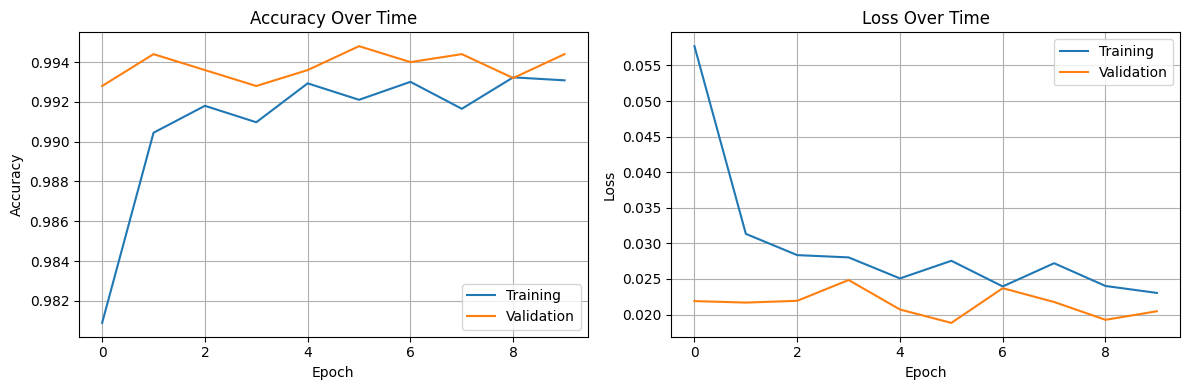

In [ ]:
attention_fused_model.plot_learning_curves()

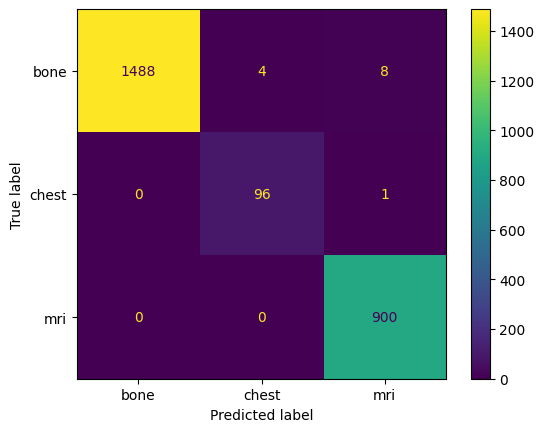

In [ ]:
attention_fused_model.plot_confusion_matrix()

In [ ]:
print(attention_fused_model.get_classification_report())

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1500
           1       0.97      0.99      0.98        97
           2       0.99      1.00      0.99       900

    accuracy                           0.99      2497
   macro avg       0.99      0.99      0.99      2497
weighted avg       0.99      0.99      0.99      2497



#Quantization

## Quantizing base models

### Quantizing

In [ ]:
# quantizing base models and saving models in specified path
quantization_results = quantize_models(base_models, data_module, quantization_dir)

In [ ]:
# Print results
for model_name, quant_results in quantization_results.items():
    print(f"\nQuantization results for {model_name}:")
    for quant_type, path in quant_results.items():
        if path:
            print(f"- {quant_type}: Successfully saved to {path}")
        else:
            print(f"- {quant_type}: Failed to quantize")

### Results

In [ ]:
quantized_manager = QuantizedModelManager(quantization_dir)

In [ ]:
# Compare model sizes
size_comparison = quantized_manager.get_model_size_comparison(base_models)
print("\nModel Size Comparison:")
size_comparison


Model Size Comparison:


,Model,Quantization,Original Size (MB),Quantized Size (MB),Size Reduction (%)
0,vgg16,max,159.76,14.15,91.14
1,vgg16,kl,159.76,14.15,91.14
2,vgg16,percentile_99,159.76,14.15,91.14
3,vgg16,full,159.76,14.15,91.14
4,resnet50,max,124.72,23.12,81.46
5,resnet50,kl,124.72,23.12,81.46
6,resnet50,percentile_99,124.72,23.12,81.46
7,resnet50,full,124.72,23.12,81.46
8,densenet121,max,29.54,7.02,76.25
9,densenet121,kl,29.54,7.02,76.25


In [ ]:
# 3. Compare and evaluate all models
results = compare_and_evaluate_models(base_models, data_module, quantization_dir)
print("\nAccuracy Comparison:")
results


Accuracy Comparison:


,Model,Quantization,Original Accuracy,Quantized Accuracy,Accuracy Drop
0,vgg16,max,98.76,98.12,0.63
1,vgg16,kl,98.76,97.50,1.26
2,vgg16,percentile_99,98.76,97.50,1.26
3,vgg16,full,98.76,97.50,1.26
4,resnet50,max,98.40,93.12,5.27
5,resnet50,kl,98.40,95.62,2.77
6,resnet50,percentile_99,98.40,90.62,7.77
7,resnet50,full,98.40,94.38,4.02
8,densenet121,max,98.80,68.75,30.05
9,densenet121,kl,98.80,61.88,36.92


### Inspecting best quantized model performace

In [ ]:

# Load the quantized model
interpreter = quantized_manager.load_quantized_model(
    model_name="vgg16",  # or any other model name
    quantization_type=QuantizationType.MAX  # or other quantization type
)

# Create predictor
predictor = QuantizedModelPredictor(interpreter)


In [ ]:
predictions = predictor.predict(data_module.test_generator)
predictions = [np.argmax(prediction) for prediction in predictions]

  0%|          | 0/79 [00:00<?, ?it/s]

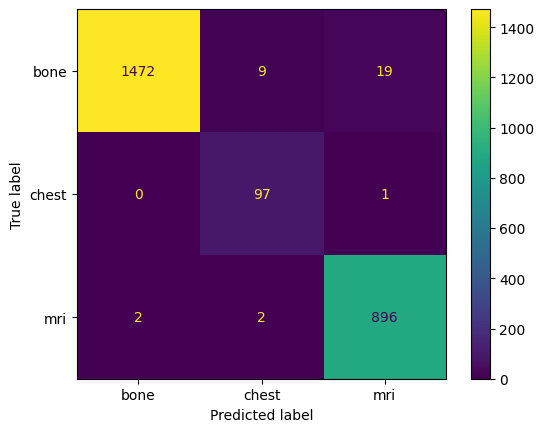

In [ ]:
plot_confusion_matrix(data_module.test_generator.classes, data_module.test_generator.labels, predictions, quantization_dir, "vgg16_max_quantized")

## Quantizing attention fused model

### Quantizing

In [ ]:
af_quantization_results = quantize_models([attention_fused_model.model], data_module, quantization_dir)

In [ ]:
# Print results
for model_name, quant_results in af_quantization_results.items():
    print(f"\nQuantization results for {model_name}:")
    for quant_type, path in quant_results.items():
        if path:
            print(f"- {quant_type}: Successfully saved to {path}")
        else:
            print(f"- {quant_type}: Failed to quantize")

In [15]:
af_quantized_manager = QuantizedModelManager(quantization_dir)

In [16]:
# Load the quantized model
af_interpreter = af_quantized_manager.load_quantized_model(
    model_name="attention_fused_model",  # or any other model name
    quantization_type=QuantizationType.FULL  # or other quantization type
)

# Create predictor
af_predictor = QuantizedModelPredictor(af_interpreter)

### Results

In [ ]:
size_comparison = af_quantized_manager.get_model_size_comparison([attention_fused_model.model])
print("\nModel Size Comparison:")
size_comparison


Model Size Comparison:


,Model,Quantization,Original Size (MB),Quantized Size (MB),Size Reduction (%)
0,attention_fused_model,max,196.03,46.08,76.49
1,attention_fused_model,kl,196.03,46.08,76.49
2,attention_fused_model,percentile_99,196.03,46.08,76.49
3,attention_fused_model,full,196.03,46.08,76.49


In [ ]:
results = compare_and_evaluate_models([attention_fused_model.model], data_module, quantization_dir)
print("\nAccuracy Comparison:")
results


Accuracy Comparison:


,Model,Quantization,Original Accuracy,Quantized Accuracy,Accuracy Drop
0,attention_fused_model,max,99.52,100.0,-0.48
1,attention_fused_model,kl,99.52,100.0,-0.48
2,attention_fused_model,percentile_99,99.52,100.0,-0.48
3,attention_fused_model,full,99.52,100.0,-0.48


In [ ]:
afm_quantized_predictions = af_predictor.predict(data_module.test_generator)
afm_quantized_predictions = [np.argmax(prediction) for prediction in afm_quantized_predictions]

  0%|          | 0/79 [00:00<?, ?it/s]

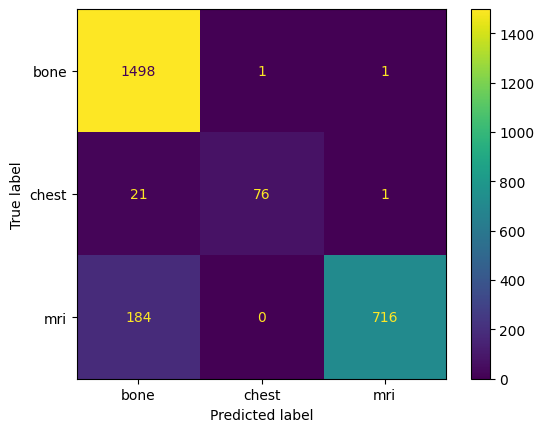

In [ ]:
plot_confusion_matrix(data_module.test_generator.classes, data_module.test_generator.labels, afm_quantized_predictions, quantization_dir, "attention_fused_max_quantized")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(data_module.test_generator.labels, afm_quantized_predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1500
           1       1.00      0.80      0.89        98
           2       1.00      0.80      0.89       900

    accuracy                           0.92      2498
   macro avg       0.96      0.86      0.90      2498
weighted avg       0.93      0.92      0.92      2498



# CBIR System

In [ ]:
cbir_system = CBIRSystem(cbir_models[0], data_dir / 'train')

In [ ]:
dataset_reader = DatasetReader(data_dir/'train')
query_image, img_sub_key, sub_keys = cbir_system.read_and_encrypt_image(dataset_reader.get_random_images_from_class(0,1)[0])

array([[[178, 188, 198],
        [177, 199, 204],
        [176, 187, 199],
        ...,
        [ 34,  42,  54],
        [  9,  17,  29],
        [131, 139, 151]],

       [[177, 192, 209],
        [177, 192, 195],
        [178, 185, 198],
        ...,
        [188, 196, 208],
        [194, 202, 214],
        [196, 204, 216]],

       [[188, 186, 197],
        [179, 191, 199],
        [178, 184, 211],
        ...,
        [178, 186, 198],
        [180, 188, 200],
        [188, 196, 208]],

       ...,

       [[177, 183, 195],
        [188, 189, 212],
        [188, 201, 216],
        ...,
        [177, 185, 197],
        [175, 185, 205],
        [178, 185, 196]],

       [[185, 202, 209],
        [177, 199, 195],
        [179, 185, 196],
        ...,
        [191, 191, 212],
        [177, 186, 197],
        [177, 186, 196]],

       [[197, 198, 196],
        [194, 186, 196],
        [177, 184, 217],
        ...,
        [196, 184, 196],
        [182, 197, 209],
        [183, 184, 206]]], dtype=uint8)
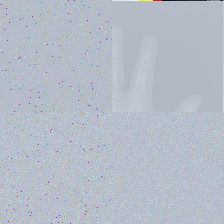

In [ ]:
cbir_system.decrypt_image((query_image, img_sub_key, sub_keys))

In [ ]:
response_images, predicted_class = cbir_system.query_similar_images(query_image, 5)
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


0

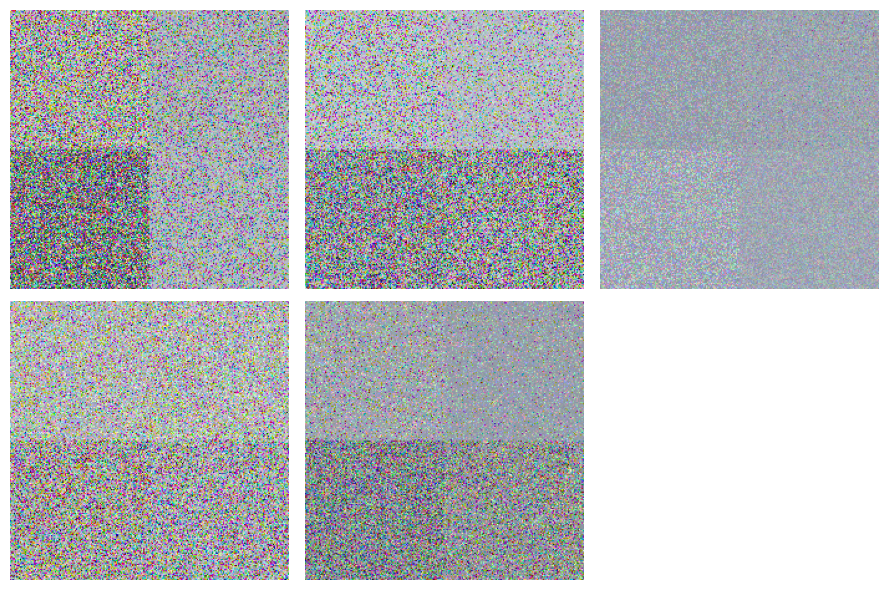

In [ ]:
plot_images([cbir_system.decrypt_image(response) for response in response_images])

In [ ]:
evaluator = CBIREvaluator(cbir_system, data_module, k=5)

evaluator.evaluate()

Starting evaluation...


Calculating mean average precision....:   0%|          | 0/79 [00:00<?, ?it/s]

Calculating recall@K....:   0%|          | 0/79 [00:00<?, ?it/s]

Measuring inference time....:   0%|          | 0/79 [00:00<?, ?it/s]

Mean Average Precision (mAP): 1.0000
Recall@5: 0.9856
Average inference time: 0.4126 seconds


In [ ]:
vgg16_cbir_system = CBIRSystem(predictor, data_dir / 'test', data_module)

In [ ]:
vgg16_evaluator = CBIREvaluator(vgg16_cbir_system, data_module, k=5)

vgg16_evaluator.evaluate()

Starting evaluation...


Calculating mean average precision....:   0%|          | 0/79 [00:00<?, ?it/s]

Calculating recall@K....:   0%|          | 0/79 [00:00<?, ?it/s]

Measuring inference time....:   0%|          | 0/79 [00:00<?, ?it/s]

Mean Average Precision (mAP): 1.0000
Recall@5: 0.9872
Average inference time: 0.3044 seconds


In [17]:
attention_quantized_cbir_system = CBIRSystem(af_predictor, data_dir / 'test', data_module)

In [18]:
aq_evaluator = CBIREvaluator(attention_quantized_cbir_system, data_module, k=5)

aq_evaluator.evaluate()

Starting evaluation...


Calculating mean average precision....:   0%|          | 0/79 [00:00<?, ?it/s]

Calculating recall@K....:   0%|          | 0/79 [00:00<?, ?it/s]

Measuring inference time....:   0%|          | 0/79 [00:00<?, ?it/s]

Mean Average Precision (mAP): 1.0000
Recall@5: 0.9215
Average inference time: 0.3854 seconds
